In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler

import seaborn as sns

from datetime import datetime

random_state = 42
np.random.seed(random_state)

In [2]:
# read the dataset
df = pd.read_csv('data/training_data.csv')
df

,timestamp,relation,train_number,delay,delay_cause
0,1667667583683,Szentendre - Batthyány tér,36H4001,0.740741,NaN
1,1667668572716,Batthyány tér - Szentendre,36H4008,0.095238,NaN
2,1667668696292,Szentendre - Batthyány tér,36H4011,0.444444,NaN
3,1667667830983,Batthyány tér - Szentendre,36H4012,3.000000,NaN
4,1667669806292,Batthyány tér - Szentendre,36H4018,0.333333,NaN
...,...,...,...,...,...
122119,1671354288630,Kecskemét - Budapest-Nyugati,552915,2.468354,Pálya állapota miatti késés
122120,1671035615214,Kőszeg - Szombathely,4339953,2.647059,NaN
122121,1671122465324,Kőszeg - Szombathely,4339953,3.714286,NaN
122122,1671208362253,Kőszeg - Szombathely,4339953,2.692308,NaN


In [3]:
# drop the delay column
df = df.drop(columns=['delay'])

# transform timestamp to hour
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x / 1000).hour)

# encode the non-numberic values
df['relation'] = df['relation'].apply(hash)
df['train_number'] = df['train_number'].apply(hash)
df['delay_cause'] = pd.Categorical(df['delay_cause']).codes

df

,timestamp,relation,train_number,delay_cause
0,17,-3511857998208853866,5713670250354152056,-1
1,18,-7891800562508338632,-753611195069495811,-1
2,18,-3511857998208853866,6589954299173811569,-1
3,18,-7891800562508338632,-2547377865172306659,-1
4,18,-7891800562508338632,4996941425615013846,-1
...,...,...,...,...
122119,10,-2317556451386536203,-29407772680228292,10
122120,17,-3809120979940295546,-387248820073650162,-1
122121,17,-3809120979940295546,-387248820073650162,-1
122122,17,-3809120979940295546,-387248820073650162,-1


In [4]:
# split the dataset into 80% training and 20% test set
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['delay_cause']), df.delay_cause, test_size=0.2, random_state=random_state)

# normalize the values
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
ros = RandomOverSampler()
X_train, Y_train = ros.fit_resample(X_train, Y_train)

In [5]:
# create a random forest classifier model
model = RandomForestClassifier(n_estimators=10, verbose=2, random_state=random_state)

# train the model
history = model.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.1s finished


In [6]:
# score the model between 0.0 and 1.0
score = model.score(X_test, Y_test)
score

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


0.5044831115660184

In [7]:
# predict delay casuses using the trained model
predictions = history.predict(X_test)

# create confusion matrix from true and predicted labels
conf = pd.crosstab(Y_test, predictions, margins=True, normalize=False)
conf = conf.apply(lambda column: column / column.iloc[len(column)-1], axis=1)

# drop the margin
conf = conf.drop(columns=['All'])
conf = conf.drop(conf.tail(1).index)

# show the confusion matrix
conf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
delay_cause,,,,,,,,,,,,,,,,,,,,
-1,0.566505,0.022788,0.062888,0.050744,0.014159,0.009456,0.008888,0.009560,0.052398,0.00124,0.001137,0.042528,0.010490,0.008165,0.039221,0.000465,0.014417,0.069864,0.001654,0.013435
0,0.212766,0.063830,0.021277,0.106383,0.021277,0.000000,0.021277,0.021277,0.106383,0.00000,0.000000,0.085106,0.021277,0.042553,0.021277,0.000000,0.085106,0.127660,0.000000,0.042553
1,0.160494,0.057613,0.102881,0.102881,0.041152,0.008230,0.024691,0.008230,0.086420,0.00000,0.000000,0.111111,0.020576,0.032922,0.086420,0.000000,0.032922,0.069959,0.016461,0.037037
2,0.104615,0.040000,0.073846,0.320000,0.033846,0.021538,0.009231,0.006154,0.055385,0.00000,0.000000,0.120000,0.015385,0.030769,0.058462,0.000000,0.018462,0.067692,0.003077,0.021538
3,0.210526,0.105263,0.263158,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.052632,0.000000,0.000000,0.052632,0.000000,0.000000,0.105263,0.000000,0.157895
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.000000,0.000000,0.090909,0.00000,0.000000,0.181818,0.000000,0.000000,0.090909,0.000000,0.000000,0.090909,0.000000,0.090909
5,0.038462,0.038462,0.076923,0.000000,0.000000,0.000000,0.230769,0.000000,0.076923,0.00000,0.000000,0.153846,0.000000,0.038462,0.153846,0.000000,0.000000,0.153846,0.000000,0.038462
6,0.187500,0.000000,0.125000,0.187500,0.000000,0.062500,0.000000,0.062500,0.000000,0.00000,0.000000,0.062500,0.062500,0.000000,0.062500,0.000000,0.000000,0.125000,0.062500,0.000000
7,0.178161,0.028736,0.109195,0.074713,0.028736,0.028736,0.028736,0.017241,0.183908,0.00000,0.000000,0.022989,0.028736,0.022989,0.045977,0.000000,0.017241,0.126437,0.005747,0.051724


In [8]:
print(classification_report(Y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

          -1       0.96      0.57      0.71     19352
           0       0.00      0.06      0.01        47
           1       0.02      0.10      0.03       243
           2       0.07      0.32      0.12       325
           3       0.00      0.00      0.00        19
           4       0.02      0.45      0.03        11
           5       0.02      0.23      0.04        26
           6       0.00      0.06      0.01        16
           7       0.02      0.18      0.04       174
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.35      0.31      0.33      1958
          11       0.03      0.31      0.05        29
          12       0.00      0.00      0.00        14
          13       0.21      0.48      0.29       560
          14       0.00      0.00      0.00         0
          15       0.00      0.02      0.00        48
          16       0.16    

<AxesSubplot: xlabel='col_0', ylabel='delay_cause'>

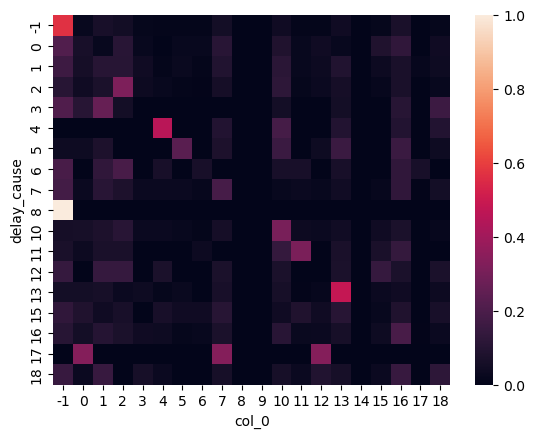

In [9]:
# show the heatmap
sns.heatmap(conf)